In [42]:

!pip install nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [43]:
# ======================
# 📚 2. DATA PREP
# ======================
def read_data(file_path):
    with open(file_path, encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
    pairs = [line.split('\t')[:2] for line in lines if '\t' in line]
    return pairs

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Zñáéíóúüç¿¡ ]+", "", text)
    return text.strip().split()

class Vocab:
    def __init__(self, sentences, min_freq=2):
        self.freq = Counter()
        for sentence in sentences:
            self.freq.update(sentence)

        self.pad = '<pad>'
        self.sos = '<sos>'
        self.eos = '<eos>'
        self.unk = '<unk>'

        self.itos = [self.pad, self.sos, self.eos, self.unk] + [w for w, c in self.freq.items() if c >= min_freq]
        self.stoi = {w: i for i, w in enumerate(self.itos)}

    def numericalize(self, tokens):
        return [self.stoi.get(token, self.stoi[self.unk]) for token in tokens]

    def denumericalize(self, indices):
        return [self.itos[i] for i in indices if i not in (self.stoi[self.pad],)]

    def __len__(self):
        return len(self.itos)


In [44]:
# ======================
# 📦 3. DATASET & DATALOADER
# ======================
class TranslationDataset(Dataset):
    def __init__(self, pairs, src_vocab, trg_vocab):
        self.data = []
        for src, trg in pairs:
            src_tokens = tokenize(src)
            trg_tokens = tokenize(trg)
            src_ids = src_vocab.numericalize(src_tokens)
            trg_ids = [trg_vocab.stoi['<sos>']] + trg_vocab.numericalize(trg_tokens) + [trg_vocab.stoi['<eos>']]
            self.data.append((src_ids, trg_ids))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_max_len = max(len(x) for x in src_batch)
    trg_max_len = max(len(x) for x in trg_batch)

    src_padded = [x + [src_vocab.stoi['<pad>']] * (src_max_len - len(x)) for x in src_batch]
    trg_padded = [x + [trg_vocab.stoi['<pad>']] * (trg_max_len - len(x)) for x in trg_batch]

    return torch.tensor(src_padded), torch.tensor(trg_padded)


In [45]:
# ======================
# 🧠 4. ENCODER
# ======================
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell


In [46]:
# ======================
# 🧠 5. BAHDAANAU ATTENTION
# ======================
class BahdanauAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.W1 = nn.Linear(hid_dim, hid_dim)
        self.W2 = nn.Linear(hid_dim, hid_dim)
        self.V = nn.Linear(hid_dim, 1)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch, hidden]
        # encoder_outputs: [batch, src_len, hidden]
        hidden = hidden.unsqueeze(1)  # [batch, 1, hidden]
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden)))  # [batch, src_len, 1]
        attn_weights = torch.softmax(score, dim=1)  # [batch, src_len, 1]
        context = torch.sum(attn_weights * encoder_outputs, dim=1)  # [batch, hidden]
        return context, attn_weights.squeeze(2)


In [47]:
# ======================
# 🧠 6. DECODER + ATTENTION
# ======================
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        context, attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = context.unsqueeze(1)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell, attn_weights


In [48]:
# ======================
# 🧠 7. SEQ2SEQ WRAPPER
# ======================
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, trg_pad_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.trg_pad_idx = trg_pad_idx

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.shape
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(device)

        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs


In [49]:
# ======================
# 🎯 8. TRAINING LOOP
# ======================
def train(model, iterator, optimizer, criterion, clip=1):
    model.train()
    total_loss = 0

    for src, trg in iterator:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]

        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(iterator)


In [50]:
# ======================
# 🧪 9. BLEU EVALUATION
# ======================
def evaluate_bleu(model, dataset, src_vocab, trg_vocab, max_len=20):
    model.eval()
    smoothie = SmoothingFunction().method4
    total_score = 0
    count = 0

    with torch.no_grad():
        for src, trg in dataset:
            src_tensor = torch.tensor([src]).to(device)
            encoder_outputs, hidden, cell = model.encoder(src_tensor)
            input_token = torch.tensor([trg_vocab.stoi['<sos>']]).to(device)
            result = []

            for _ in range(max_len):
                output, hidden, cell, _ = model.decoder(input_token, hidden, cell, encoder_outputs)
                top1 = output.argmax(1)
                if top1.item() == trg_vocab.stoi['<eos>']:
                    break
                result.append(top1.item())
                input_token = top1

            pred_tokens = trg_vocab.denumericalize(result)
            reference_tokens = trg_vocab.denumericalize(trg[1:-1])
            score = sentence_bleu([reference_tokens], pred_tokens, smoothing_function=smoothie)
            total_score += score
            count += 1

    return total_score / count


In [57]:
# ======================
# 📊 10. ATTENTION VISUALIZATION
# ======================
def show_attention(attn_weights, input_tokens, output_tokens):
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(attn_weights[:len(output_tokens), :len(input_tokens)], xticklabels=input_tokens, yticklabels=output_tokens, cmap='viridis')
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.show()


In [52]:
# ======================
# 🚀 11. RUN EVERYTHING
# ======================
# Load dataset
raw_pairs = read_data("/content/spa.txt")
train_pairs, val_pairs = train_test_split(raw_pairs, test_size=0.1)

src_vocab = Vocab([tokenize(p[0]) for p in train_pairs])
trg_vocab = Vocab([tokenize(p[1]) for p in train_pairs])

train_dataset = TranslationDataset(train_pairs, src_vocab, trg_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Model setup
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
EMB_DIM = 256
HID_DIM = 512

attention = BahdanauAttention(HID_DIM)
encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, attention)
model = Seq2Seq(encoder, decoder, trg_pad_idx=trg_vocab.stoi['<pad>']).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab.stoi['<pad>'])

# Train
for epoch in range(10):
    loss = train(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Epoch 1, Loss: 4.1468
Epoch 2, Loss: 2.4784
Epoch 3, Loss: 1.8610
Epoch 4, Loss: 1.5162
Epoch 5, Loss: 1.2965
Epoch 6, Loss: 1.1401
Epoch 7, Loss: 1.0190
Epoch 8, Loss: 0.9154
Epoch 9, Loss: 0.8356
Epoch 10, Loss: 0.7708


In [56]:
# Train
for epoch in range(10):
    loss = train(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 0.7108
Epoch 2, Loss: 0.6612
Epoch 3, Loss: 0.6236
Epoch 4, Loss: 0.5883
Epoch 5, Loss: 0.5553
Epoch 6, Loss: 0.5250
Epoch 7, Loss: 0.5059
Epoch 8, Loss: 0.4885
Epoch 9, Loss: 0.4723
Epoch 10, Loss: 0.4603


In [60]:
# Evaluate BLEU score
val_dataset = TranslationDataset(val_pairs, src_vocab, trg_vocab)
bleu_score = evaluate_bleu(model, val_dataset, src_vocab, trg_vocab)
print(f"\nAverage BLEU Score on Validation Set: {bleu_score*100:.4f}")



Average BLEU Score on Validation Set: 78.1200


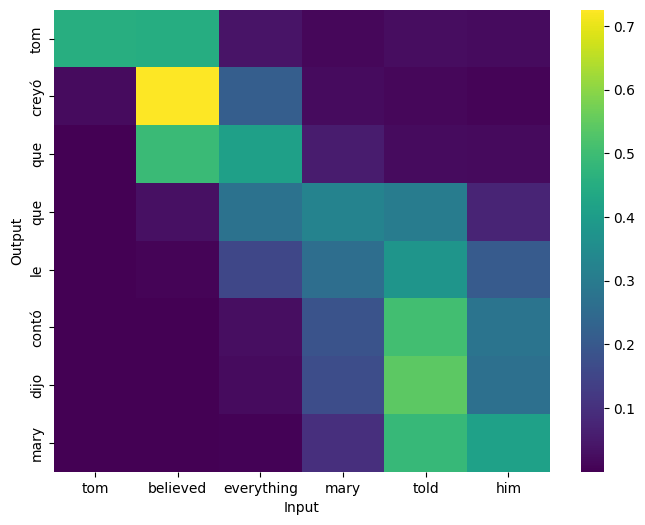

In [58]:
# Visualize attention on one example
def visualize_sample(index=0):
    model.eval()
    src, trg = val_dataset[index]
    src_tensor = torch.tensor([src]).to(device)
    encoder_outputs, hidden, cell = model.encoder(src_tensor)
    input_token = torch.tensor([trg_vocab.stoi['<sos>']]).to(device)

    result = []
    attentions = []

    with torch.no_grad():
        for _ in range(20):
            output, hidden, cell, attn = model.decoder(input_token, hidden, cell, encoder_outputs)
            top1 = output.argmax(1)
            if top1.item() == trg_vocab.stoi['<eos>']:
                break
            result.append(top1.item())
            attentions.append(attn.squeeze(0).cpu().numpy())
            input_token = top1

    pred_tokens = trg_vocab.denumericalize(result)
    input_tokens = src_vocab.denumericalize(src)

    attn_matrix = np.stack(attentions)  # [tgt_len, src_len]
    show_attention(attn_matrix, input_tokens, pred_tokens)

# Call to visualize
visualize_sample(index=0)
